In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Paths to the dataset
data_dir = "AffectNet"
labels_file = os.path.join(data_dir, "labels.csv")

# Load labels from the CSV file
labels_df = pd.read_csv(labels_file)

# Define the emotions in the dataset (excluding 'contempt')
emotions = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion_to_label = {emotion: idx for idx, emotion in enumerate(emotions)}

# Filter out rows with the 'contempt' label
labels_df = labels_df[~labels_df['label'].isin(['contempt'])]

# Function to load images and match them with labels
def load_images_and_labels(data_dir, labels_df, img_size=(96, 96)):
    images = []
    labels = []
    for _, row in labels_df.iterrows():
        img_path = os.path.join(data_dir, row['pth'])
        label = row['label']
        
        if label in emotion_to_label and os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(emotion_to_label[label])
        else:
            print(f"Skipping image: {img_path} or invalid label: {label}")
    
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(data_dir, labels_df)

# Normalize images and expand dimensions
images = images / 255.0
images = np.expand_dims(images, axis=-1)

# Convert labels to one-hot encoding
num_classes = len(emotions)
labels = to_categorical(labels, num_classes)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (19944, 96, 96, 1), (19944, 7)
Testing data shape: (4987, 96, 96, 1), (4987, 7)


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.30, seed=42),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.30, seed=42),

    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.30, seed=42),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.35, seed=42),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 94, 94, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 43, 43, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 43, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 17, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,158,215 (8.23 MB)

 Trainable params: 2,157,319 (8.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [2]:
from tensorflow.keras.models import load_model

model=load_model("affectnet_model_best.keras")


In [3]:
from keras.callbacks import ModelCheckpoint

# Save the best model during training
checkpoint = ModelCheckpoint("affectnet_model_best.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9603 - loss: 0.1354
Epoch 1: val_accuracy improved from -inf to 0.66292, saving model to affectnet_model_best.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 233s 738ms/step - accuracy: 0.9603 - loss: 0.1354 - val_accuracy: 0.6629 - val_loss: 2.5080
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9536 - loss: 0.1512
Epoch 2: val_accuracy did not improve from 0.66292
312/312 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.9536 - loss: 0.1512 - val_accuracy: 0.6587 - val_loss: 2.2809
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9591 - loss: 0.1358
Epoch 3: val_accuracy improved from 0.66292 to 0.66453, saving model to affectnet_model_best.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.9591 - loss: 0.1358 - val_accuracy: 0.6645 - val_loss: 2.3609
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.9623 - loss: 0.1267
Epoch 4: val_accuracy did not improve from 0.664

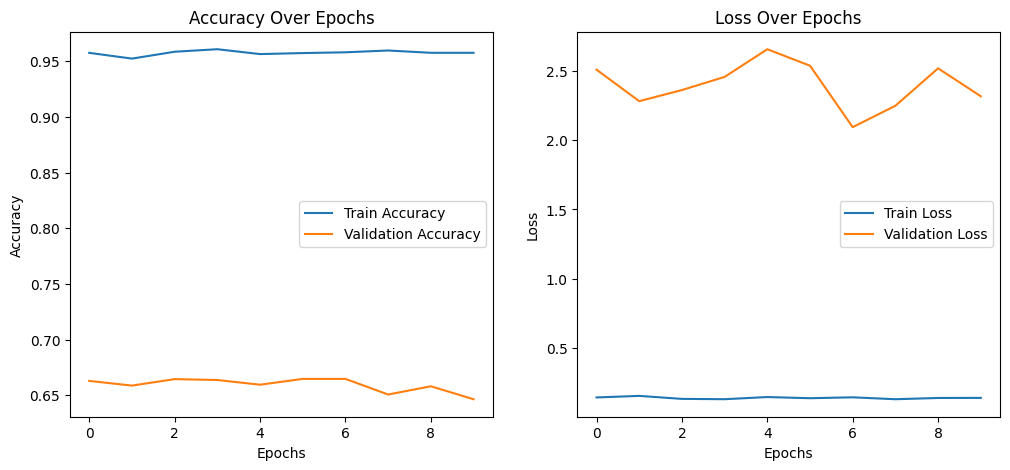

In [7]:
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [5]:
from keras.models import load_model

# Load the best saved model
saved_model = load_model("affectnet_model_best.keras")

# Evaluate on test data
test_loss, test_acc = saved_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")



156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.6633 - loss: 2.4514
Test Accuracy: 0.66


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


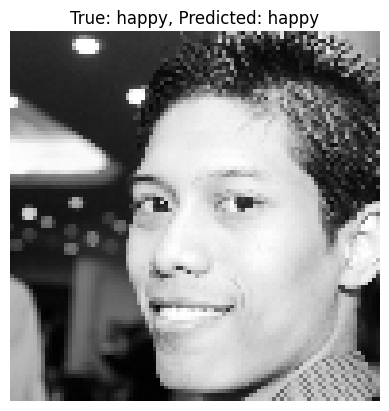

In [6]:
# Random test sample
idx = np.random.randint(len(X_test))
test_image = X_test[idx]
test_label = np.argmax(y_test[idx])

# Predict emotion
predicted_label = np.argmax(saved_model.predict(np.expand_dims(test_image, axis=0)))

# Plot the image
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f"True: {emotions[test_label]}, Predicted: {emotions[predicted_label]}")
plt.axis('off')
plt.show()
